# <span style = "background-color: #FFDDDD"> 도로 영역을 찾자! - 세그멘테이션 모델 만들기</span>

⭐️ U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가? KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.  
⭐️ U-Net++ 모델이 성공적으로 구현되었는가? U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.   
⭐️ U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가? U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.

---
## <span style = "background-color: #FFFFDD"> 🚗 Environment Settings</span>

### <span style = "background-color: #F0E9FF"> 1. Import libraries & packages </span>

In [1]:
# useful tools
import math
import random
import copy

# dataset path & filenames
import os
import glob

# data array
import numpy as np

# image data handling & augmentation
from PIL import Image
import skimage.io
import skimage.transform
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, Resize

# visualization
import matplotlib.pyplot as plt

# machine learning
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *

### <span style = "background-color: #F0E9FF"> 2. Define constants</span>

In [2]:
TRAIN_PATH = os.getenv("HOME") + "/aiffel/semantic_segmentation/data/training"
TEST_PATH = os.getenv("HOME") + "/aiffel/semantic_segmentation/data/testing"

NUM_CLASSES = 28

IMG_SIZE = 224

AUG_PROB = 0.5    # probability of performing augmentation

In [3]:
# model training configurations
BATCH_SIZE = 16
EPOCHS = 100

UNET_PATH = os.getenv("HOME") + "/aiffel/semantic_segmentation/seg_model_unet.h5"
UNETPP_PATH = os.getenv("HOME") + "/aiffel/semantic_segmentation/seg_model_unetpp.h5"

### <span style = "background-color: #F0E9FF"> 3. Define frequently used methods</span>

In [4]:
DIVIDER_LENGTH = 80

def print_single_divider(length = DIVIDER_LENGTH):
    print("-" * DIVIDER_LENGTH)

def print_double_divider(length = DIVIDER_LENGTH):
    print("=" * DIVIDER_LENGTH)

### <span style = "background-color: #F0E9FF"> 4. Check GPU settings</span>

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---
## <span style = "background-color: #FFFFDD"> 🚗 Data Preparation</span>

### <span style = "background-color: #F0E9FF"> 1. Preview dataset</span>

**1-1. Load filenames of the dataset**

In [6]:
# load filenames of input(original) image data
ds_train_input_filenames = glob.glob(os.path.join(TRAIN_PATH, "image_2", "*.png"))
ds_train_input_filenames.sort()

# load filenmaes of target(segmented) image data
ds_train_target_filenames = glob.glob(os.path.join(TRAIN_PATH, "semantic", "*.png"))
ds_train_target_filenames.sort()

In [7]:
print("> Total number of training data samples :", len(ds_train_input_filenames))

> Total number of training data samples : 200


**1-2. Preview the dataset**

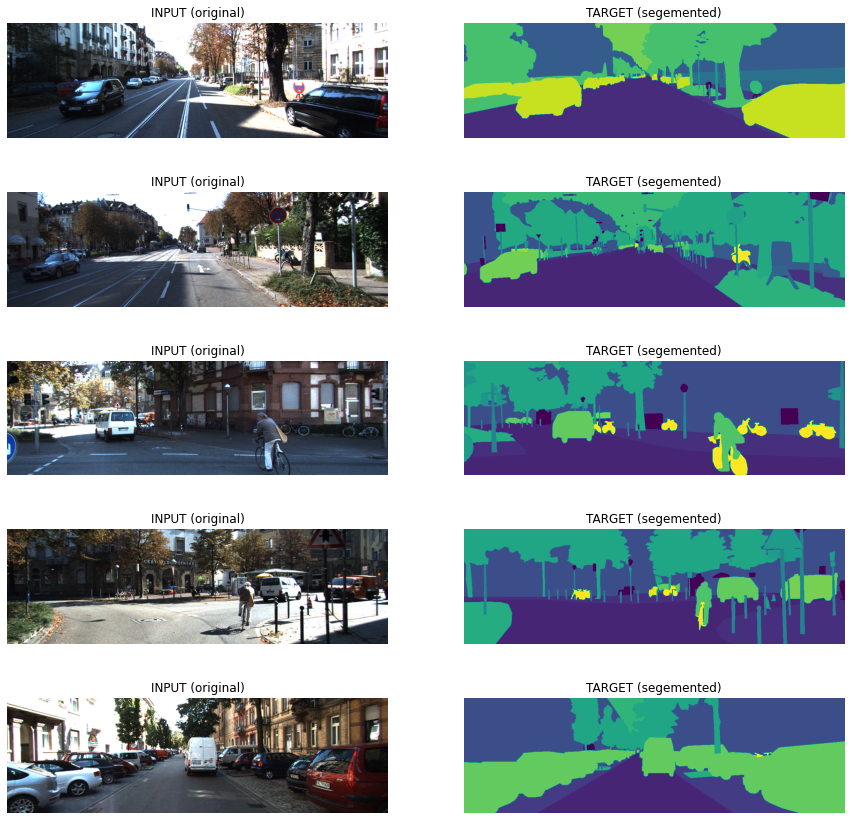

In [8]:
fig = plt.figure(figsize=(15,15))

for i in range(5):
    # preview the input(original) image data
    ax_input = fig.add_subplot(5, 2, 2*i+1)
    ax_input.imshow(skimage.io.imread(ds_train_input_filenames[i]))
    ax_input.set_title("INPUT (original)")
    ax_input.axis("off")
    
    # preview the corresponding target(segmented) image data
    ax_target = fig.add_subplot(5, 2, 2*i+2)
    ax_target.imshow(skimage.io.imread(ds_train_target_filenames[i]))
    ax_target.set_title("TARGET (segemented)")
    ax_target.axis("off")

plt.show()

### <span style = "background-color: #F0E9FF"> 2. Define augmentation methods</span>

**2-1. Define augmentation methods**

In [9]:
def build_augmentation(is_train=True):
    if is_train == True:    # 훈련용 데이터일 경우
        return Compose([HorizontalFlip(p=AUG_PROB),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(               # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=IMG_SIZE,
                            width=IMG_SIZE,
                            p=AUG_PROB),
                        Resize(width=IMG_SIZE,         # 입력이미지를 224X224로 resize
                               height=IMG_SIZE)
                       ])
    
    else:    # is_train == False
        return Compose([Resize(width=IMG_SIZE,         # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                               height=IMG_SIZE)
                       ])

**2-2. Generate augmentor instances**

In [10]:
augmentor_train = build_augmentation(is_train=True)
augmentor_val = build_augmentation(is_train=False)

**2-3. Test operation of the augmentors**

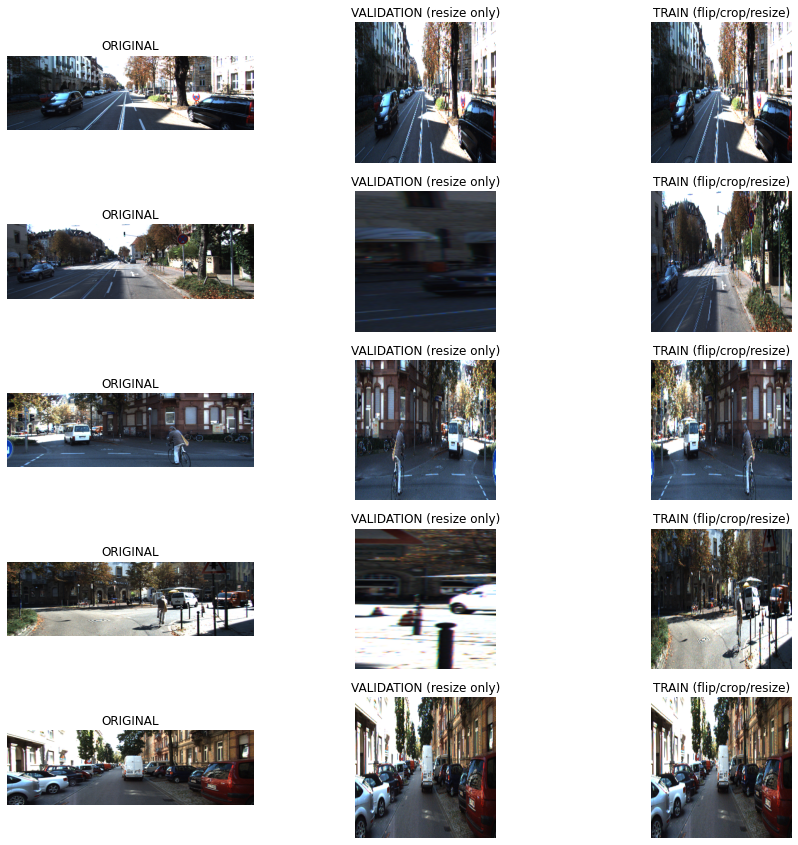

In [11]:
fig = plt.figure(figsize=(15,15))

for i in range(5):
    sample = skimage.io.imread(ds_train_input_filenames[i])
    sample_dict = {"image": sample}
    
    # preform augmentation
    augmented_train = augmentor_train(**sample_dict)
    augmented_val = augmentor_val(**sample_dict)
    
    # preview the original image data
    ax_original = fig.add_subplot(5, 3, 3*i+1)
    ax_original.imshow(sample)
    ax_original.set_title("ORIGINAL")
    ax_original.axis("off")
    
    # preview the validation-augmented image data
    ax_val = fig.add_subplot(5, 3, 3*i+2)
    ax_val.imshow(augmented_train["image"])
    ax_val.set_title("VALIDATION (resize only)")
    ax_val.axis("off")
    
    # preview the train-augmented image data
    ax_train = fig.add_subplot(5, 3, 3*i+3)
    ax_train.imshow(augmented_val["image"])
    ax_train.set_title("TRAIN (flip/crop/resize)")
    ax_train.axis("off")

plt.show()

### <span style = "background-color: #F0E9FF"> 3. Define data preparation pipeline methods</span>

In [12]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    
    # set parameters with initial values & load dataset
    def __init__(self,
                 dir_path,
                 batch_size=BATCH_SIZE,
                 img_size=(IMG_SIZE, IMG_SIZE, 3),
                 output_size=(IMG_SIZE, IMG_SIZE),
                 is_train=True,
                 augmentation=None):
        '''
        - dir_path : dataset의 directory path입니다.
        - batch_size : batch_size입니다.
        - img_size : preprocess에 사용할 입력이미지의 크기입니다.
        - output_size : ground_truth를 만들어주기 위한 크기입니다.
        - is_train : 이 Generator가 학습용인지 테스트용인지 구분합니다.
        - augmentation : 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        
        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()
        
    
    
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob.glob(os.path.join(self.dir_path, "image_2", "*.png"))
        input_images.sort()
        
        target_images = glob.glob(os.path.join(self.dir_path, "semantic", "*.png"))
        target_images.sort()
        
        assert len(input_images) == len(target_images)
        data = [ _ for _ in zip(input_images, target_images)]
        
        if self.is_train:
            return data[:-30]
        
        return data[-30:]
    
    
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)
    
    
    
    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[index*self.batch_size:(index + 1)*self.batch_size]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = skimage.io.imread(input_img_path)
            _output = skimage.io.imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {"image": _input, "mask": _output,}
            
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        
        return inputs, outputs
    
    
    
    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            
        return self.indexes

### <span style = "background-color: #F0E9FF"> 4. Prepare training & validation data</span>

In [13]:
ds_train = KittiGenerator(TRAIN_PATH, augmentation=augmentor_train, is_train=True)
ds_val = KittiGenerator(TRAIN_PATH, augmentation=augmentor_val, is_train=False)

print("> All training and validation data prepared successfully!")

> All training and validation data prepared successfully!


---
## <span style = "background-color: #FFFFDD"> 🚗 Model Preparation</span>

### <span style = "background-color: #F0E9FF"> 1. Design basic blocks</span>

In [14]:
def contract_block(inputs, filters, kernel_size=3, pooling=True, plusplus=False):
    if plusplus == False:    # vanilla U-net
        activation = "relu"
    else:    # U-net++
        activation = None
    
    conv = inputs
    for _ in range(2):
        conv = Conv2D(filters, kernel_size, padding="same", activation=activation)(conv)
    
        #if plusplus == True:    # U-net++
        #    conv = BatchNormalization()(conv)
        #    conv = Activation("relu")(conv)
        # 해당 부분은 학습 수행 시 memory trouble ... 일단은 주석처리 😭
        
    pool = None
    if pooling == True:
        pool = MaxPooling2D(pool_size=2)(conv)
    
    return conv, pool

In [15]:
def expand_block(inputs, connections, filters, kernel_size=3):
    activation = "relu"
    
    upsampled = Conv2DTranspose(filters, kernel_size-1, strides=2, padding="same")(inputs)
    concatenated = Concatenate()([upsampled, connections])
    
    conv = concatenated
    conv = Conv2D(filters, kernel_size, activation=activation, padding="same")(conv)
    conv = Conv2D(filters, kernel_size, activation=activation, padding="same")(conv)
    
    return conv

### <span style = "background-color: #F0E9FF"> 2. Prepare U-net model</span>

**2-1. Define U-net model structure**

In [16]:
def get_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=1, plusplus=False):
   
    # input layer
    inputs = Input(input_shape)
    
    # contracting path
    conv1, pool1 = contract_block(inputs, 64, pooling=True, plusplus=plusplus)
    conv2, pool2 = contract_block(pool1, 128, pooling=True, plusplus=plusplus)
    conv3, pool3 = contract_block(pool2, 256, pooling=True, plusplus=plusplus)
    conv4, pool4 = contract_block(pool3, 512, pooling=True, plusplus=plusplus)
    
    # bottom
    conv5, _ = contract_block(pool4, 1024, pooling=False, plusplus=plusplus)
    
    # expanding path
    conv6 = expand_block(conv5, conv4, 512)
    conv7 = expand_block(conv6, conv3, 256)
    conv8 = expand_block(conv7, conv2, 128)
    conv9 = expand_block(conv8, conv1, 64)

    # output layer
    output = Conv2D(num_classes, (1, 1), activation="sigmoid")(conv9)

    model = Model(inputs=inputs, outputs=output)
    return model

**2-2. Generate U-net model instance**

In [17]:
unet_model = get_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3), plusplus=False)
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### <span style = "background-color: #F0E9FF"> 3. Prepare U-net++ model</span>

**3-1. Define U-net++ model structure**

In [18]:
def get_unetpp(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_class=1, deep_supervision=False):

    # input layer
    inputs = Input(input_shape)

    # contracting path 1
    conv1_1, pool1 = contract_block(inputs, 64, pooling=True, plusplus=True)
    
    # contracting path 2
    conv2_1, pool2 = contract_block(pool1, 128, pooling=True, plusplus=True)

    up1_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], axis=3)
    conv1_2, _ = contract_block(conv1_2, 64, pooling=False, plusplus=True)
    
    # contracting path 3
    conv3_1, pool3 = contract_block(pool2, 256, pooling=True, plusplus=True)

    up2_2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3_1)
    conv2_2 = Concatenate()([up2_2, conv2_1])
    conv2_2, _ = contract_block(conv2_2, 128, pooling=False, plusplus=True)

    up1_3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv2_2)
    conv1_3 = Concatenate()([up1_3, conv1_1, conv1_2])
    conv1_3, _ = contract_block(conv1_3, 64, pooling=False, plusplus=True)

    # contracting path 4
    conv4_1, pool4 = contract_block(pool3, 512, pooling=True, plusplus=True)

    up3_2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1])
    conv3_2, _ = contract_block(conv3_2, 256, pooling=False, plusplus=True)

    up2_3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2])
    conv2_3, _ = contract_block(conv2_3, 128, pooling=False, plusplus=True)

    up1_4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3])
    conv1_4, _ = contract_block(conv1_4, 64, pooling=False, plusplus=True)

    
    # bottom
    conv5_1, _ = contract_block(pool4, 1024, pooling=False, plusplus=True)

    
    # expanding path 1
    up4_2 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1])
    conv4_2, _ = contract_block(conv4_2, 512, pooling=False, plusplus=True)
    
    # expanding path 2
    up3_3 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2])
    conv3_3, _ = contract_block(conv3_3, 256, pooling=False, plusplus=True)

    # expanding path 3
    up2_4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3])
    conv2_4, _ = contract_block(conv2_4, 128, pooling=False, plusplus=True)

    # expanding path 4
    up1_5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4])
    conv1_5, _ = contract_block(conv1_5, 64, pooling=False, plusplus=True)

    
    # output layer
    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = tf.keras.Model(inputs=inputs, outputs=[nestnet_output_1,
                                               nestnet_output_2,
                                               nestnet_output_3,
                                               nestnet_output_4])
    else:
        model = tf.keras.Model(inputs=inputs, outputs=[nestnet_output_4])

    return model

**3-2. Generate U-net++ model instance**

In [19]:
unetpp_model = get_unetpp(input_shape=(IMG_SIZE, IMG_SIZE, 3))
unetpp_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

---
## <span style = "background-color: #FFFFDD"> 🚗 Train models</span>

### <span style = "background-color: #F0E9FF"> 1. Define training performance metrics evaluation methods</span>

In [20]:
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

In [21]:
def iou_score(target, prediction):
    target = tf.convert_to_tensor(target, dtype=tf.float32)
    prediction = tf.convert_to_tensor(prediction, dtype=tf.float32)

    intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.cast(target, tf.bool), tf.cast(prediction, tf.bool)), tf.float32))
    union = tf.reduce_sum(tf.cast(tf.logical_or(tf.cast(target, tf.bool), tf.cast(prediction, tf.bool)), tf.float32))
    
    iou_score = tf.math.divide_no_nan(intersection, union)
    
    return iou_score

### <span style = "background-color: #F0E9FF"> 2. Train models</span>

**2-1. Train U-net model**

In [22]:
unet_model.compile(optimizer = Adam(1e-4), loss = "binary_crossentropy", metrics=[dice_coefficient, iou_score])

unet_history = unet_model.fit(ds_train,
                              validation_data=ds_val,
                              steps_per_epoch=len(ds_train),
                              epochs=EPOCHS,)

Epoch 1/100
11/11 [==============================] - 29s 814ms/step - loss: 0.6837 - dice_coefficient: 0.3026 - iou_score: 0.2271 - val_loss: 0.6555 - val_dice_coefficient: 0.3032 - val_iou_score: 0.2302
Epoch 2/100
11/11 [==============================] - 9s 740ms/step - loss: 0.6148 - dice_coefficient: 0.2326 - iou_score: 0.2148 - val_loss: 0.5935 - val_dice_coefficient: 0.2637 - val_iou_score: 0.2302
Epoch 3/100
11/11 [==============================] - 8s 729ms/step - loss: 0.5760 - dice_coefficient: 0.2175 - iou_score: 0.2021 - val_loss: 0.5619 - val_dice_coefficient: 0.2411 - val_iou_score: 0.2302
Epoch 4/100
11/11 [==============================] - 8s 709ms/step - loss: 0.5134 - dice_coefficient: 0.2517 - iou_score: 0.2051 - val_loss: 0.4512 - val_dice_coefficient: 0.3409 - val_iou_score: 0.2302
Epoch 5/100
11/11 [==============================] - 8s 719ms/step - loss: 0.4070 - dice_coefficient: 0.3660 - iou_score: 0.2134 - val_loss: 0.3749 - val_dice_coefficient: 0.4192 - val_io

11/11 [==============================] - 8s 708ms/step - loss: 0.1556 - dice_coefficient: 0.7548 - iou_score: 0.2021 - val_loss: 0.1734 - val_dice_coefficient: 0.7933 - val_iou_score: 0.2302
Epoch 42/100
11/11 [==============================] - 8s 708ms/step - loss: 0.1699 - dice_coefficient: 0.7267 - iou_score: 0.2116 - val_loss: 0.1876 - val_dice_coefficient: 0.7757 - val_iou_score: 0.2302
Epoch 43/100
11/11 [==============================] - 8s 709ms/step - loss: 0.1416 - dice_coefficient: 0.8117 - iou_score: 0.2216 - val_loss: 0.1899 - val_dice_coefficient: 0.7695 - val_iou_score: 0.2302
Epoch 44/100
11/11 [==============================] - 8s 702ms/step - loss: 0.1604 - dice_coefficient: 0.7759 - iou_score: 0.2228 - val_loss: 0.1827 - val_dice_coefficient: 0.7537 - val_iou_score: 0.2302
Epoch 45/100
11/11 [==============================] - 8s 710ms/step - loss: 0.1535 - dice_coefficient: 0.7690 - iou_score: 0.2129 - val_loss: 0.1847 - val_dice_coefficient: 0.7757 - val_iou_score: 

11/11 [==============================] - 8s 702ms/step - loss: 0.1236 - dice_coefficient: 0.8203 - iou_score: 0.2161 - val_loss: 0.1512 - val_dice_coefficient: 0.8211 - val_iou_score: 0.2302
Epoch 82/100
11/11 [==============================] - 8s 710ms/step - loss: 0.1085 - dice_coefficient: 0.8492 - iou_score: 0.2210 - val_loss: 0.1416 - val_dice_coefficient: 0.8339 - val_iou_score: 0.2302
Epoch 83/100
11/11 [==============================] - 8s 712ms/step - loss: 0.1127 - dice_coefficient: 0.8304 - iou_score: 0.2014 - val_loss: 0.1513 - val_dice_coefficient: 0.8100 - val_iou_score: 0.2302
Epoch 84/100
11/11 [==============================] - 8s 706ms/step - loss: 0.1113 - dice_coefficient: 0.8361 - iou_score: 0.2119 - val_loss: 0.2046 - val_dice_coefficient: 0.7869 - val_iou_score: 0.2345
Epoch 85/100
11/11 [==============================] - 8s 713ms/step - loss: 0.1034 - dice_coefficient: 0.8468 - iou_score: 0.2082 - val_loss: 0.1618 - val_dice_coefficient: 0.8206 - val_iou_score: 

**2-2. Train U-net++ model** 

In [23]:
unetpp_model.compile(optimizer = Adam(1e-4), loss = "binary_crossentropy", metrics=[dice_coefficient, iou_score])

unetpp_history = unetpp_model.fit(ds_train,
                                  validation_data=ds_val,
                                  steps_per_epoch=len(ds_train),
                                  epochs=EPOCHS,)

Epoch 1/100
11/11 [==============================] - 39s 2s/step - loss: 0.6157 - dice_coefficient: 0.2592 - iou_score: 0.2225 - val_loss: 0.6663 - val_dice_coefficient: 0.1809 - val_iou_score: 0.2302
Epoch 2/100
11/11 [==============================] - 20s 2s/step - loss: 0.5576 - dice_coefficient: 0.2471 - iou_score: 0.2146 - val_loss: 0.5444 - val_dice_coefficient: 0.2432 - val_iou_score: 0.2302
Epoch 3/100
11/11 [==============================] - 20s 2s/step - loss: 0.4609 - dice_coefficient: 0.3159 - iou_score: 0.2078 - val_loss: 0.3500 - val_dice_coefficient: 0.4969 - val_iou_score: 0.2302
Epoch 4/100
11/11 [==============================] - 20s 2s/step - loss: 0.3759 - dice_coefficient: 0.4454 - iou_score: 0.2193 - val_loss: 0.4516 - val_dice_coefficient: 0.4991 - val_iou_score: 0.2302
Epoch 5/100
11/11 [==============================] - 20s 2s/step - loss: 0.3971 - dice_coefficient: 0.4897 - iou_score: 0.2127 - val_loss: 0.3669 - val_dice_coefficient: 0.4316 - val_iou_score: 0.

11/11 [==============================] - 20s 2s/step - loss: 0.1769 - dice_coefficient: 0.7631 - iou_score: 0.2327 - val_loss: 0.1860 - val_dice_coefficient: 0.7566 - val_iou_score: 0.2302
Epoch 42/100
11/11 [==============================] - 20s 2s/step - loss: 0.1813 - dice_coefficient: 0.7384 - iou_score: 0.2126 - val_loss: 0.1785 - val_dice_coefficient: 0.7871 - val_iou_score: 0.2302
Epoch 43/100
11/11 [==============================] - 20s 2s/step - loss: 0.1732 - dice_coefficient: 0.7532 - iou_score: 0.2178 - val_loss: 0.2104 - val_dice_coefficient: 0.7520 - val_iou_score: 0.2302
Epoch 44/100
11/11 [==============================] - 20s 2s/step - loss: 0.1995 - dice_coefficient: 0.7329 - iou_score: 0.2249 - val_loss: 0.2281 - val_dice_coefficient: 0.6756 - val_iou_score: 0.2302
Epoch 45/100
11/11 [==============================] - 20s 2s/step - loss: 0.1905 - dice_coefficient: 0.7393 - iou_score: 0.2169 - val_loss: 0.1742 - val_dice_coefficient: 0.7625 - val_iou_score: 0.2302
Epo

Epoch 82/100
11/11 [==============================] - 20s 2s/step - loss: 0.1335 - dice_coefficient: 0.8013 - iou_score: 0.2101 - val_loss: 0.1775 - val_dice_coefficient: 0.7664 - val_iou_score: 0.2302
Epoch 83/100
11/11 [==============================] - 20s 2s/step - loss: 0.1409 - dice_coefficient: 0.7961 - iou_score: 0.2136 - val_loss: 0.1735 - val_dice_coefficient: 0.7749 - val_iou_score: 0.2302
Epoch 84/100
11/11 [==============================] - 20s 2s/step - loss: 0.1418 - dice_coefficient: 0.7789 - iou_score: 0.2151 - val_loss: 0.1583 - val_dice_coefficient: 0.8176 - val_iou_score: 0.2302
Epoch 85/100
11/11 [==============================] - 20s 2s/step - loss: 0.1498 - dice_coefficient: 0.7962 - iou_score: 0.2139 - val_loss: 0.1911 - val_dice_coefficient: 0.7395 - val_iou_score: 0.2302
Epoch 86/100
11/11 [==============================] - 20s 2s/step - loss: 0.1592 - dice_coefficient: 0.7680 - iou_score: 0.2073 - val_loss: 0.1778 - val_dice_coefficient: 0.7434 - val_iou_scor

### <span style = "background-color: #F0E9FF"> 3. Visualize training history</span>

**3-1. Define history visualizing methods**

In [24]:
def visualize_history(history):
    fig = plt.figure(figsize=(15,5))
    
    # visualize training & validation loss
    graph1 = fig.add_subplot(1, 3, 1)
    graph1.plot(history.history["loss"], color="lightpink", label="training")
    graph1.plot(history.history["val_loss"], color="palevioletred", label="validation")
    graph1.set_title("L O S S")
    graph1.set_xlabel("epochs")
    graph1.set_ylabel("loss")
    graph1.grid()
    graph1.legend()
        
    # visualize training & validation accuracy
    graph2 = fig.add_subplot(1, 3, 2)
    graph2.plot(history.history["dice_coefficient"], color="thistle", label="training")
    graph2.plot(history.history["val_dice_coefficient"], color="orchid", label="validation")
    graph2.set_title("D I C E   C O E F F C I E N T")
    graph2.set_xlabel("epochs")
    graph2.set_ylabel("coeff")
    graph2.grid()
    graph2.legend()
    
    # visualize training & validation binary accuracy
    graph3 = fig.add_subplot(1, 3, 3)
    graph3.plot(history.history["iou_score"], color="paleturquoise", label="training")
    graph3.plot(history.history["val_iou_score"], color="lightseagreen", label="validation")
    graph3.set_title("I O U")
    graph3.set_xlabel("epochs")
    graph3.set_ylabel("IOU")
    graph3.grid()
    graph3.legend()   

    fig.tight_layout()
    fig.show()

**3-2. Visualize U-net model training history**

>>> U-net model training evaluation   :


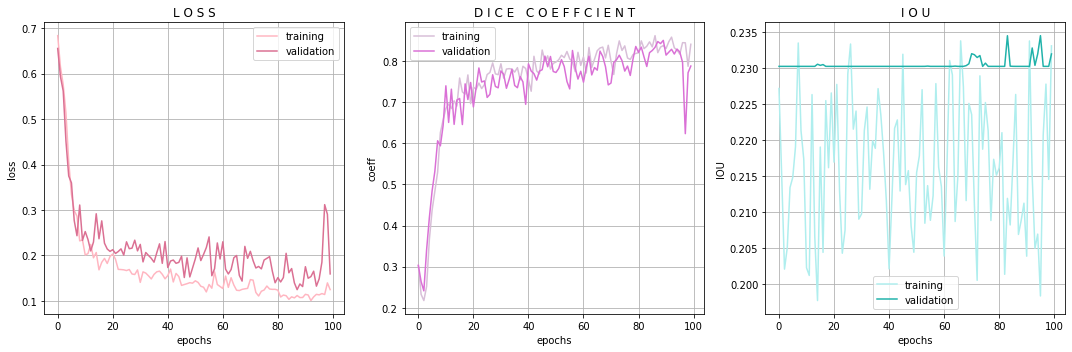

In [25]:
print(">>> U-net model training evaluation   :")
visualize_history(unet_history)

**3-3. Visualize U-net++ model training history**

>>> U-net++ model training evaluation :


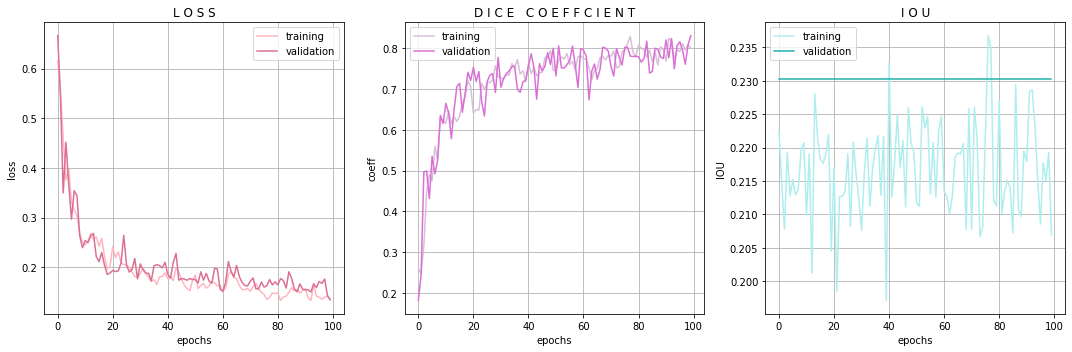

In [26]:
print(">>> U-net++ model training evaluation :")
visualize_history(unetpp_history)

📝 **모델 학습 성능 분석**

- U-net의 경우 loss는 하향, dice coefficient는 상향하면서 모델 학습의 성능이 전반적으로 향상되는 추세를 보이다가, EPOCH=90 이후 갑자기 성능이 하락하였다. IOU의 경우, 특별히 상항/하향하는 것이 아니라 20% 초반대의 범위 내에서 요동치는 양상을 보였다.

- U-net++의 경우 loss는 하향, dice coefficient는 상향하면서 모델 학습의 성능이 전반적으로 향상되는 추세를 보였다. IOU는 U-net과 마찬가지로 특별히 상향/하향하는 것이 아니라 20% 초반대의 범위 내에서 요동치는 양상을 보였다.

---
## <span style = "background-color: #FFFFDD"> 🚗 Experiments</span>

### <span style = "background-color: #F0E9FF"> 1. Define evaluation methods</span>

**1-1. Define segmentation result visualizing methods**

In [27]:
def get_output(model, preproc, input_path, output_path, target_path):
    origin_img = skimage.io.imread(input_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
     
    if target_path:   
        target_img = skimage.io.imread(target_path)
        target_data = {"image":target_img}
        target_processed = preproc(**target_data)
        target_processed = target_processed["image"]
        target = (target_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    
    else:
        return output, prediction, _

**1-2. Define IOU calculation methods**

In [28]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction) # intersection을 구하는 코드를 작성해주세요.
    union = np.logical_or(target, prediction) # Union을 구하는 코드를 작성해주세요.
    iou_score = np.sum(intersection) / np.sum(union) # iou 스코어를 구하되 결과값을 float로 만들어주세요!

    return iou_score

### <span style = "background-color: #F0E9FF"> 2. Define experiment method</span>

In [29]:
def do_experiment(sample_num=1):
    
    # get one sample by the sample number
    input_path = TRAIN_PATH + f'/image_2/00{str(sample_num).zfill(4)}_10.png'
    output_path = TRAIN_PATH + f'./result_{str(sample_num).zfill(3)}.png'
    target_path = TRAIN_PATH + f'/semantic/00{str(sample_num).zfill(4)}_10.png'
    
    
    
    # get experimental results
    original_img = skimage.io.imread(input_path)
    original_height, original_width, _ = original_img.shape
    
    output_img1, prediction_img1, target_img1 = get_output(unet_model, 
                                                    augmentor_val,
                                                    input_path=input_path,
                                                    output_path=output_path,
                                                    target_path=target_path)
    iou_score1 = calculate_iou_score(target_img1, prediction_img1)
    #prediction_img1 = Resize(prediction_img)
    
    output_img2, prediction_img2, target_img2 = get_output(unetpp_model, 
                                                    augmentor_val,
                                                    input_path=input_path,
                                                    output_path=output_path,
                                                    target_path=target_path)
    iou_score2 = calculate_iou_score(target_img2, prediction_img2)
    
    
    
    # display experimental results
    fig = plt.figure(figsize=(15,15))
    
    ax_original = fig.add_subplot(3, 2, 1)
    ax_original.imshow(original_img)
    ax_original.set_title("ORIGINAL")
    ax_original.axis("off")
    
    ax_target = fig.add_subplot(3, 2, 2)
    ax_target.imshow(target_img2)
    ax_target.set_title("SEGMENTATION TARGET")
    ax_target.axis("off")
    
    ax_output1 = fig.add_subplot(3, 2, 3)
    ax_output1.imshow(output_img1)
    ax_output1.set_title("U-net (IOU : " + str(iou_score1) + ")")
    ax_output1.axis("off")
    
    ax_prediction1 = fig.add_subplot(3, 2, 4)
    ax_prediction1.imshow(prediction_img1)
    ax_prediction1.set_title("U-net (IOU : " + str(iou_score1) + ")")
    ax_prediction1.axis("off")
    
    ax_output2 = fig.add_subplot(3, 2, 5)
    ax_output2.imshow(output_img2)
    ax_output2.set_title("U-net++ (IOU : " + str(iou_score2) + ")")
    ax_output2.axis("off")
    
    ax_prediction2 = fig.add_subplot(3, 2, 6)
    ax_prediction2.imshow(prediction_img2)
    ax_prediction2.set_title("U-net++ (IOU : " + str(iou_score2) + ")")
    ax_prediction2.axis("off")
    
    plt.show()

### <span style = "background-color: #F0E9FF"> 3. Perform experiments</span>

**3-1. Experiment 1**

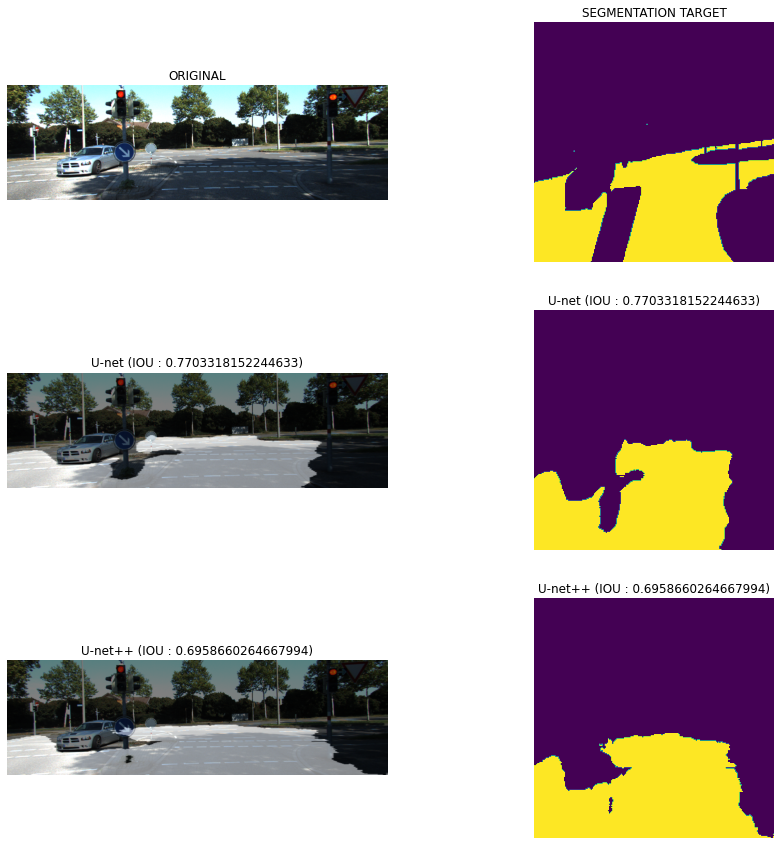

In [30]:
do_experiment(random.randint(1, 200))

**3-2. Experiment 2**

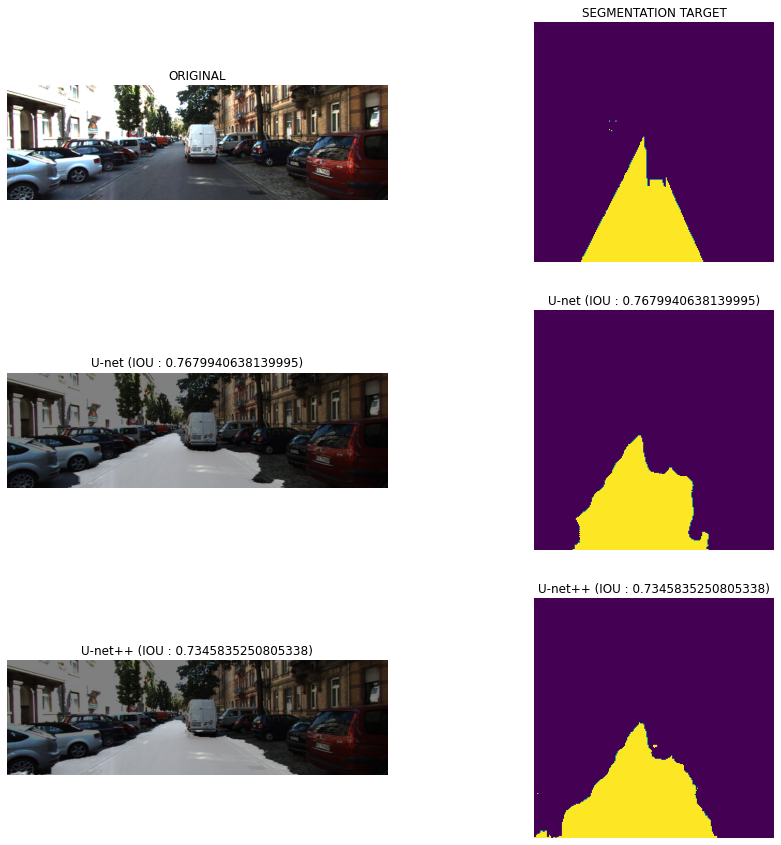

In [31]:
do_experiment(random.randint(1, 200))

**3-3. Experiment 3**

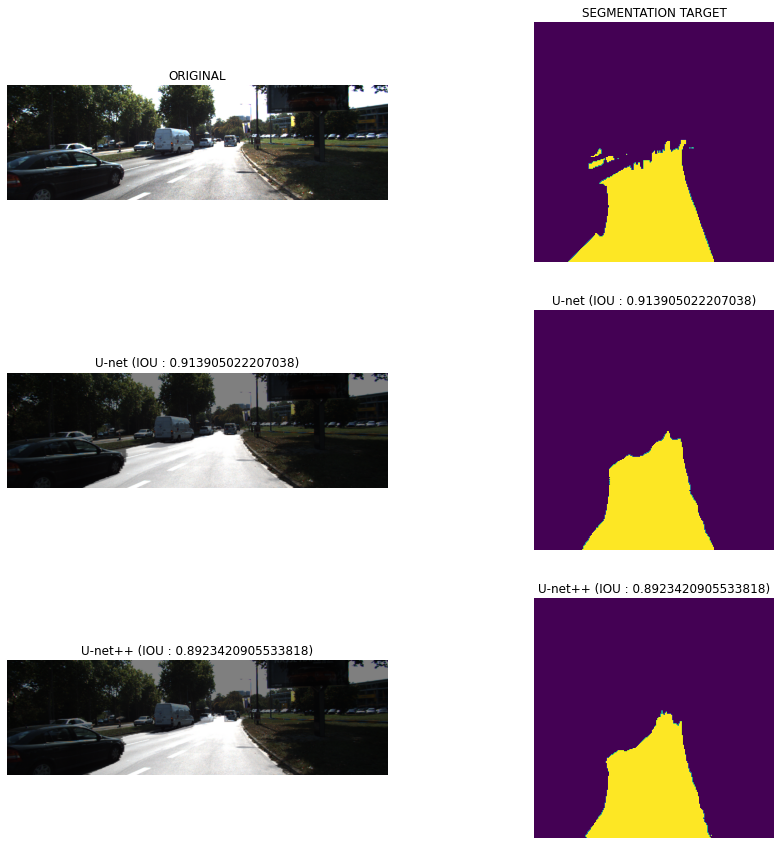

In [32]:
do_experiment(random.randint(1, 200))

**3-4. Experiment 4**

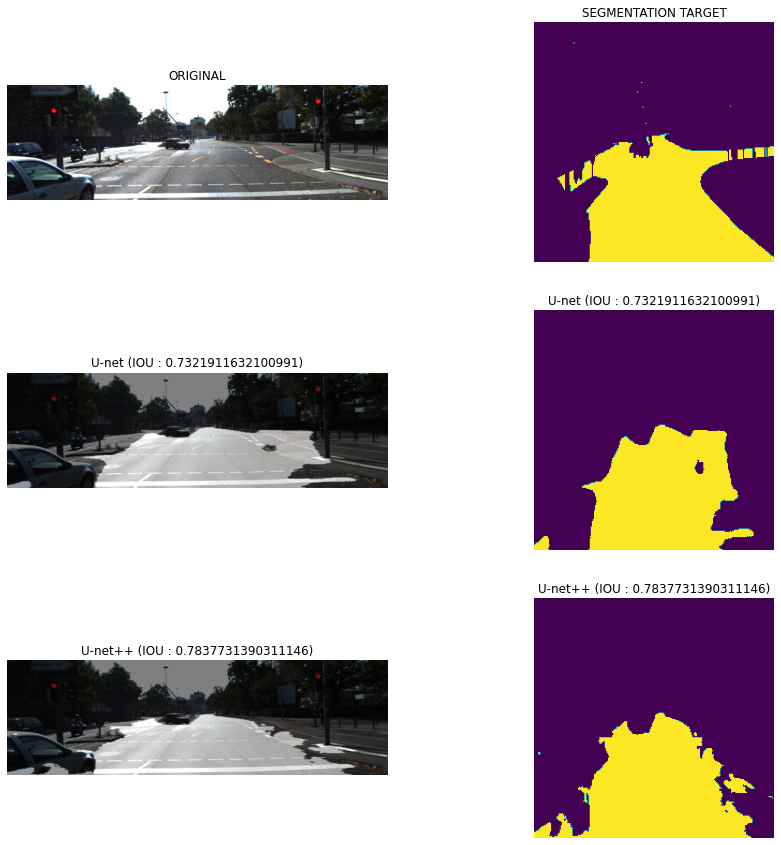

In [33]:
do_experiment(random.randint(1, 200))

**3-5. Experiment 5**

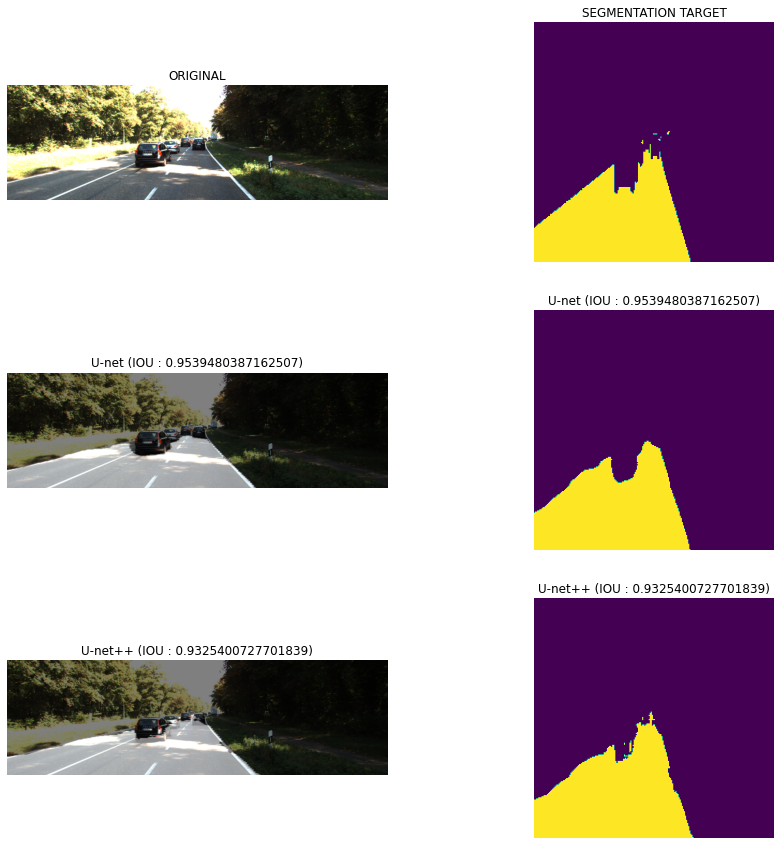

In [34]:
do_experiment(random.randint(1, 200))

**3-6. Experiment 6**

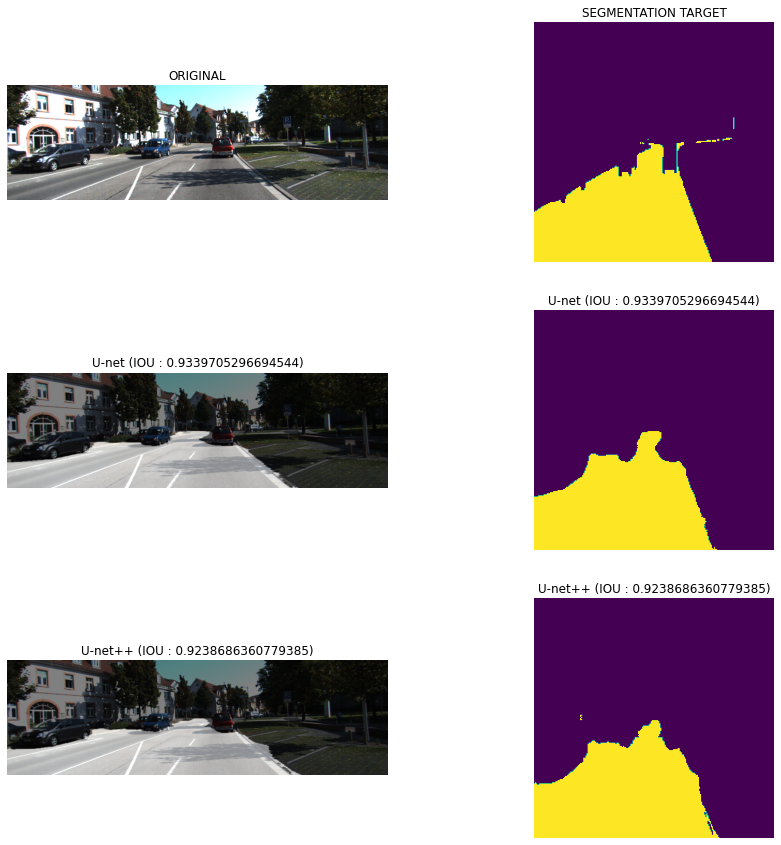

In [35]:
do_experiment(random.randint(1, 200))

**3-7. Experiment 7**

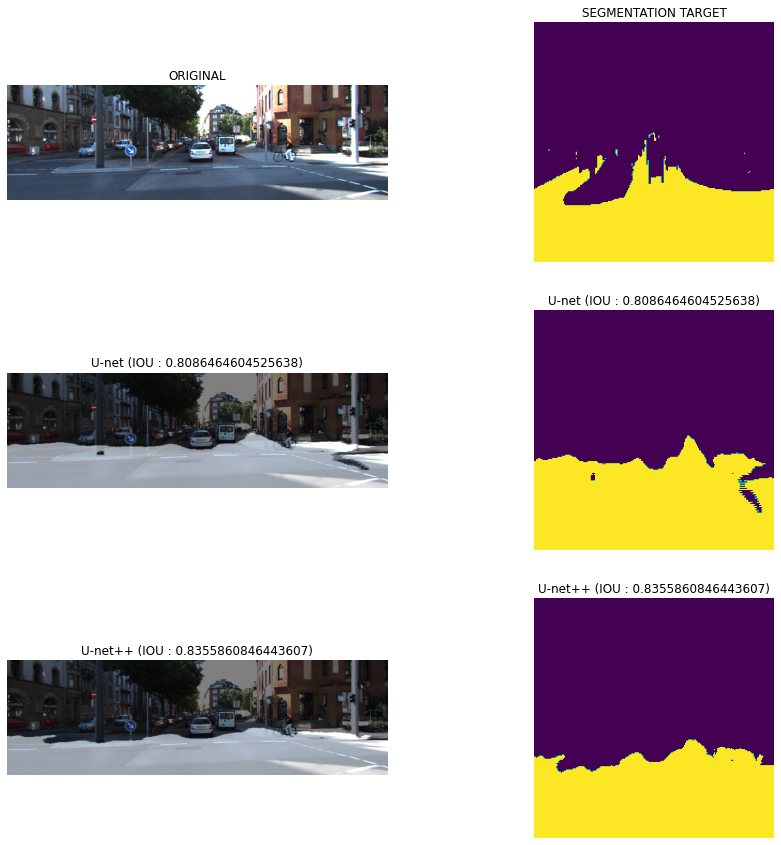

In [36]:
do_experiment(random.randint(1, 200))

**3-8. Experiment 8**

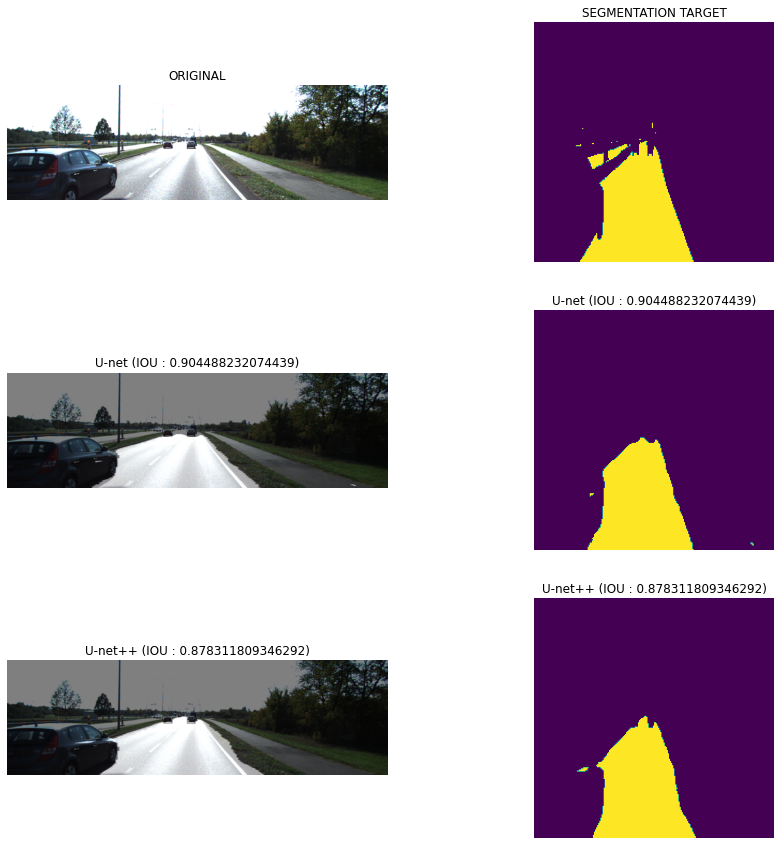

In [37]:
do_experiment(random.randint(1, 200))

**3-9. Experiment 9**

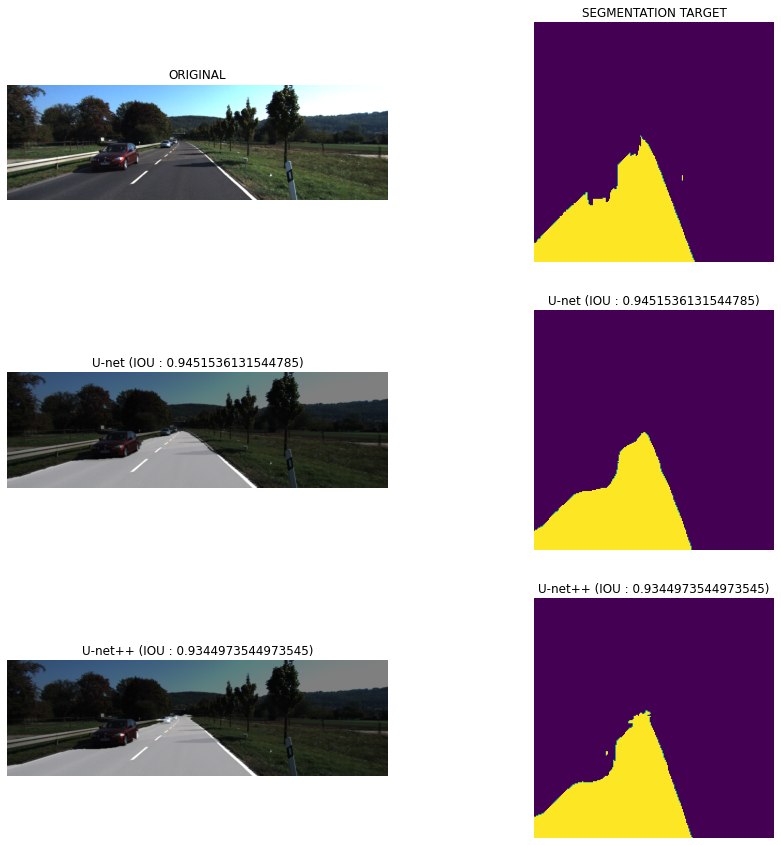

In [38]:
do_experiment(random.randint(1, 200))

**3-10. Experiment 10**

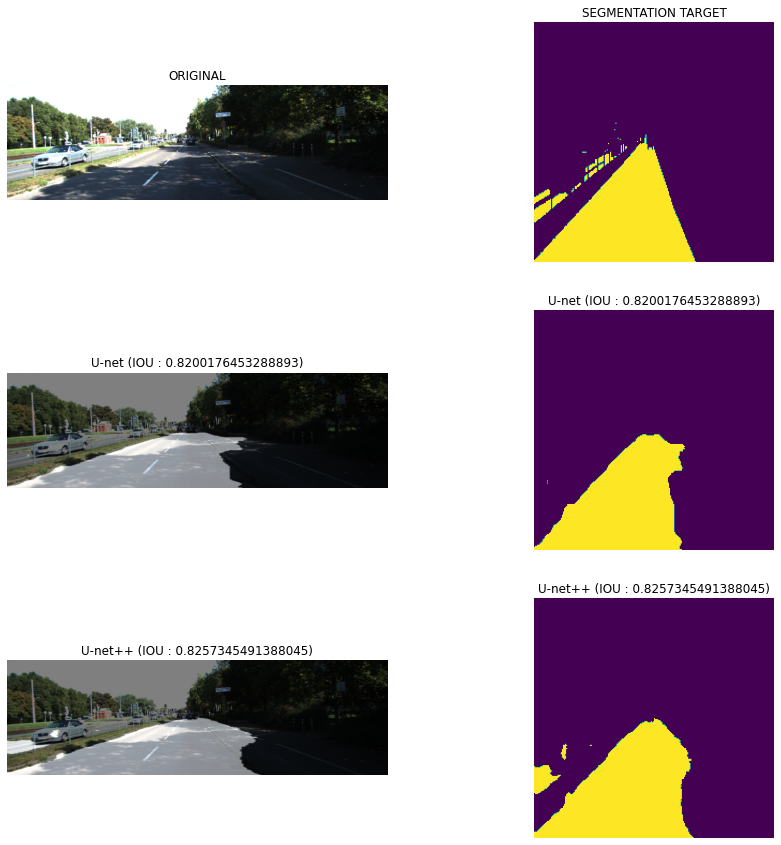

In [39]:
do_experiment(random.randint(1, 200))

---
## <span style = "background-color: #FFFFDD"> 🚗 Conclusion</span>

**📝 실험결과 분석**

- IOU 수치에 의하면 비슷한 확률로 U-net이 더 높거나 U-net++이 더 높았다. 이번 실험만으로는, 특히 IOU만으로는 두 모델의 성능을 비교하기가 어려운 것 같다.

- segmentation 결과를 봤을 때, U-net++가 "길" 그 자체를 훨씬 더 잘 잡아내는 것 같다. 다만, 실제로 차량이 주행 가능 여부와 상관없이 모든 "길"을 다 잡아내었다. 건물 및 다른 객체의 주변이나, 차량이 진입할 수 없는 길(인도, 좁거나 막혀있는 길 등) 등 모든 길을 다 잡아내었다. 반면에 U-net의 경우 넓은 부분의 길만 잡아냄으로서 실제로 차량이 진입 가능한 길을 표시하는 경우가 많았다. 따라서 단순한 "길 감지"에는 U-net++가 훌륭한 성능을 보이나, 실제 차량 주행 상황에 적응할 때는 오히려 U-net이 더 나은 성능을 갖췄다고 평가할 수 있다.

**📝 회고록**  

- U-net++에 skip connection이 복잡하게 얽혀있어서 구현하는 것이 쉽지 않았다. 다른 사람들의 코드를 참고하려고 시도 하였으나, 버전 충돌 문제 등 쉽지 않았다. 다만 "남의 코드 읽기"에 느꼈던 장벽이 많이 허물어지면서 발전할 수 있는 계기가 되었다.

- U-net++의 구조에 대해서 좀 더 명확하게 이해하고, backbone network 부분도 구현할 수 있었다면 더욱 좋았을텐데... 🥲 일단 오늘은 여기까지.

- detection만으로는 성능의 한계가 있을 것이다. U-net++ 실험의 예와 같이, 길을 탐지하더라도 실제 차량이 진입 가능한 길이 아니라면 소용 없기 때문이다. detection 결과와 네비게이션 정보를 참조해서 정확도를 보완하면 더욱 좋을 것 같다 😁 

---